# Hands-on Lab --- Churn Modeling

## Importing some standard packages, as well as packages needed for modeling:

In [24]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.base import TransformerMixin

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

## import modeling data created in the Data Prep pipeline

In [25]:
combined_df = pd.read_csv(r'C:\Users\Ashish\OneDrive - Oklahoma A and M System\CLV\combined_data.csv')

C:\Users\Ashish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Using the head method to preview our data:

In [26]:
combined_df.demog_age

0         35-44 years old
1         35-44 years old
2         55-64 years old
3         55-64 years old
4         45-54 years old
5         65-74 years old
6         55-64 years old
7                     NaN
8         45-54 years old
9                     NaN
10        65-74 years old
11        55-64 years old
12        55-64 years old
13        45-54 years old
14          75+ years old
15        55-64 years old
16        45-54 years old
17        55-64 years old
18          75+ years old
19        55-64 years old
20        55-64 years old
21        45-54 years old
22        25-34 years old
23          75+ years old
24                    NaN
25        25-34 years old
26        35-44 years old
27        55-64 years old
28        45-54 years old
29        55-64 years old
30        35-44 years old
31        65-74 years old
32        35-44 years old
33        55-64 years old
34        55-64 years old
35          75+ years old
36        35-44 years old
37        55-64 years old
38          

## Doing some basic exploratory analysis:

In [27]:
""" Analyzing average values of numeric variables, by the levels of the binary target variable """
print(" ") 
print("averages by churn ind")
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['log_purch_amt_life'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['scheduled_purchase_flg'].mean())

print(" ") 
print(" ") 
print(combined_df.groupby('churn_year_plus1_ind')['months_since_last_trans'].mean())

 
averages by churn ind
 
churn_year_plus1_ind
0    2.99
1    2.48
Name: log_purch_amt_life, dtype: float64
 
 
churn_year_plus1_ind
0    3.52e-01
1    4.31e-03
Name: scheduled_purchase_flg, dtype: float64
 
 
churn_year_plus1_ind
0    1.76
1    6.15
Name: months_since_last_trans, dtype: float64


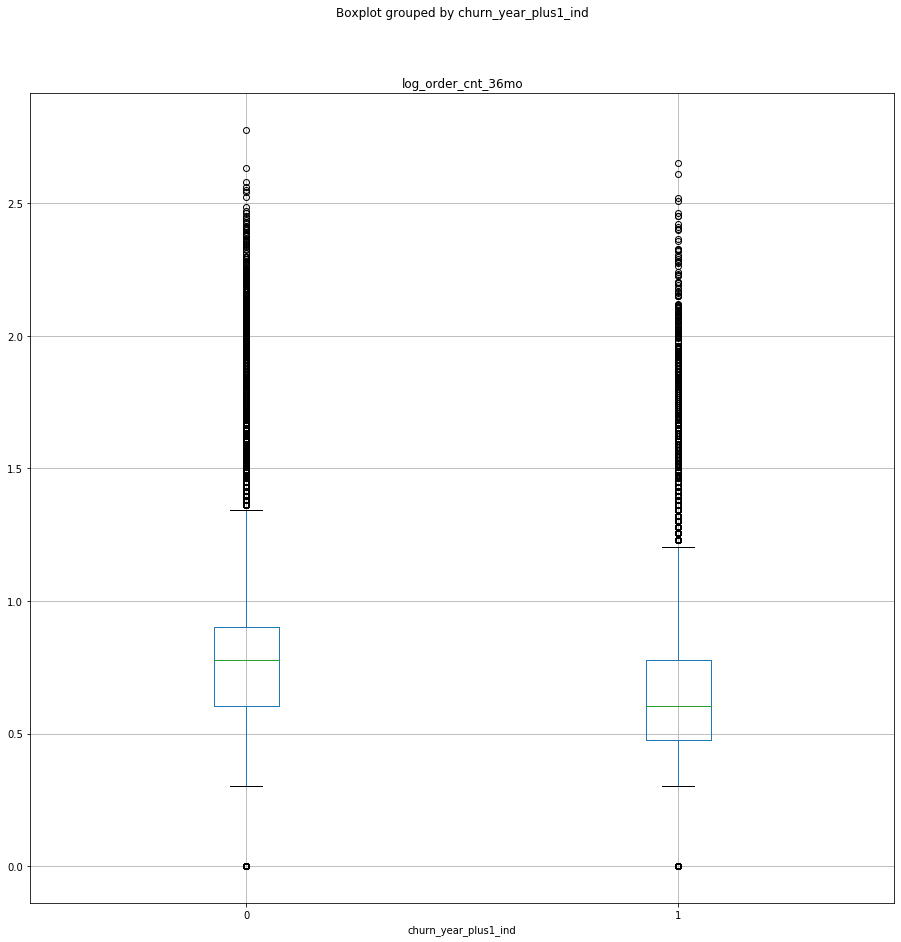

In [28]:
""" A boxplot to investigate the distribution of numeric variables by the levels of the target """

combined_df.boxplot(column='log_order_cnt_36mo', by='churn_year_plus1_ind',figsize=(15,15))

## Printing variable stats:

In [29]:
print(" summary stats on combined data ") 
print(combined_df.describe(include='all').transpose())

 summary stats on combined data 
                                 count  unique              top    freq     mean      std      min      25%      50%      75%      max
ST                              240368      61               TX   21643      NaN      NaN      NaN      NaN      NaN      NaN      NaN
Zip                             240368   26096          missing     892      NaN      NaN      NaN      NaN      NaN      NaN      NaN
DMA                             240368     428              803    9381      NaN      NaN      NaN      NaN      NaN      NaN      NaN
Area_Cd                         240368     384          missing   13083      NaN      NaN      NaN      NaN      NaN      NaN      NaN
emailable                      2.4e+05     NaN              NaN     NaN     0.51      0.5        0        0        1        1        1
solicit_ph_ind                 2.4e+05     NaN              NaN     NaN     0.89     0.31        0        1        1        1        1
solicit_email_ind     

## Dropping variables we don't want included in modeling, and creating new version of data for modeling:

In [30]:
""" Any categorical variable for which we did not create dummy indicators        """
"""    and other variables we don't want in the model, or which don't make sense """
"""    to be included in model training, we are dropping here:                   """

""" Note:  we also want to drop acct_ID, but we are going to do that after partioning """
"""        because we need acct_ID for partioned sets to for reference later          """

x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date',
                            'ST','tier','tier_prev','demog_LOR','demog_ownrent','demog_age','demog_homevalue_num'
                              ],axis=1)

x_train_df.shape

(240368, 125)

AttributeError: 'DataFrame' object has no attribute 'ST'

## Partitioning data into Training and Test sets, creating X vs Y sets, and
##     creating dataframes with just account IDs to be used to rejoin data later:

In [31]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30)

""" will need the acct_IDs to rejoin data later, so pulling out now before dropping from actual model training data """

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]

""" the target (or dependent) variable is stored in it's own dataframe """

y_train_df = x_train_df[['churn_year_plus1_ind']]
y_test_df  = x_test_df[['churn_year_plus1_ind']]

""" and we want to drop acct_ID and the target variable from the dataframe of independent variables """
""" PLUS we want to drop the target (future timeframe) variables for margin modeling                """

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'
                             ],axis=1)

x_train_df.shape

(168257, 121)

In [32]:
x_train_df.ST

AttributeError: 'DataFrame' object has no attribute 'ST'

In [9]:
x_train_df.isnull().sum()

emailable                            0
solicit_ph_ind                       0
solicit_email_ind                    0
fixd_incm_flg                        0
scheduled_purchase_flg               0
months_since_last_trans              0
months_since_first_trans             0
purch_avg_interval                   0
mail_cnt_36mo                        0
call_in_mo_36mo                      0
call_out_mo_36mo                     0
log_order_cnt_36mo                   0
log_purch_amt_36mo                   0
log_purch_amt_life                   0
log_purch_avg_36mo                   0
log_purch_cnt_life                   0
log_purch_cnt_tt_36mo                0
log_resp_cnt_36mo                    0
perc_purch_cc_36mo                   0
perc_purch_ck_36mo                   0
perc_purch_et_36mo                   0
margin_Y_neg_1                       0
margin_Y_neg_2                       0
margin_Y_neg_3                       0
margin_3yr_avg                       0
log_margin_Y_neg_1       

In [10]:
class DataFrameImputer(TransformerMixin):
    
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

x_train_df= DataFrameImputer().fit_transform(x_train_df)
x_test_df = DataFrameImputer().fit_transform(x_test_df)

In [11]:
x_train_df.isnull().sum()

emailable                        0
solicit_ph_ind                   0
solicit_email_ind                0
fixd_incm_flg                    0
scheduled_purchase_flg           0
months_since_last_trans          0
months_since_first_trans         0
purch_avg_interval               0
mail_cnt_36mo                    0
call_in_mo_36mo                  0
call_out_mo_36mo                 0
log_order_cnt_36mo               0
log_purch_amt_36mo               0
log_purch_amt_life               0
log_purch_avg_36mo               0
log_purch_cnt_life               0
log_purch_cnt_tt_36mo            0
log_resp_cnt_36mo                0
perc_purch_cc_36mo               0
perc_purch_ck_36mo               0
perc_purch_et_36mo               0
margin_Y_neg_1                   0
margin_Y_neg_2                   0
margin_Y_neg_3                   0
margin_3yr_avg                   0
log_margin_Y_neg_1               0
log_margin_Y_neg_2               0
log_margin_Y_neg_3               0
log_margin_3yr_avg  

## Starting with a scikit_learn Logistic Regression Model
##    and using that modeling algorithm to select variables.

## Note:  change the C parameter and rerun to get reasonable number of selected vars.

In [12]:
""" models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero """
""" SelectFromModel can be used to to select effects with non-zero coefficients """
""" the parameter C controls the sparsity: the smaller C the fewer features selected """

""" using the ravel simply to avoid warning in log """
y_train_array=np.ravel(y_train_df)

""" start with C = 1.0, then try 0.1, etc """
model1 = linear_model.LogisticRegression(C=0.01, solver='liblinear', penalty='l1', tol=0.01)
model1_fit = model1.fit(x_train_df, y_train_df)
model1_selects = SelectFromModel(model1_fit, prefit=True)
"""x_train_selected_df = model1_selects.transform(x_train_df)"""

""" in lieu of commented-out transform method above, can use this method to explicitly define columns to keep """
x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]

coefficients = pd.DataFrame(model1_fit.coef_)
coefficients = np.transpose(coefficients[coefficients.columns[model1_selects.get_support()]])
coefficients = coefficients.reset_index(drop=True)

coefficients_match = pd.concat([pd.DataFrame(x_train_selected_df.columns),coefficients], axis = 1)

coefficients.shape 

C:\Users\Ashish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(49, 1)

In [13]:
print(" ") 
print("Coefficients for selected variables")
coefficients_match.head(40)

 
Coefficients for selected variables


,0,0
0,emailable,-8.72e-02
1,solicit_ph_ind,-6.71e-01
2,solicit_email_ind,1.74e-01
3,scheduled_purchase_flg,-2.44e+00
4,months_since_last_trans,3.24e-01
5,months_since_first_trans,-4.46e-04
6,purch_avg_interval,3.22e-03
7,mail_cnt_36mo,1.17e-03
8,call_in_mo_36mo,-6.63e-04
9,call_out_mo_36mo,-2.84e-02


## Need to introduce variable reduction that addresses multicolinearity:

In [14]:
x_train_selected_df.shape

(168257, 49)

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
        else:
            dropped=False
    print('Remaining variables:')
    print(X.columns[variables])        
        
    return X.iloc[:, variables]

x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

dropping 'log_margin_3yr_avg' at index: 25
dropping 'log_margin_Y_neg_2' at index: 23
dropping 'log_margin_Y_neg_1' at index: 22
dropping 'log_purch_amt_36mo' at index: 11
dropping 'log_margin_Y_neg_3' at index: 21
dropping 'log_purch_amt_life' at index: 11
dropping 'perc_purch_ck_36mo' at index: 16
dropping 'log_purch_cnt_tt_36mo' at index: 13
dropping 'tier_prev_xxx' at index: 30
dropping 'log_purch_cnt_life' at index: 12
dropping 'solicit_email_ind' at index: 2
dropping 'log_purch_avg_36mo' at index: 10
dropping 'tier_1-Bronze' at index: 20
dropping 'log_order_cnt_36mo' at index: 9
Remaining variables:
Index(['emailable', 'solicit_ph_ind', 'scheduled_purchase_flg', 'months_since_last_trans', 'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1', 'margin_Y_neg_2', 'demog_generations', 'demog_adults', 'ST_NC', 'ST_PA', 'ST_WA', 'tier_2-Silver', 'tier_3-

(168257, 35)

## Reducing test set to match train set.

In [16]:
""" reducing the test set to have the same columns as the training set """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]
print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['emailable', 'solicit_ph_ind', 'scheduled_purchase_flg', 'months_since_last_trans', 'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo', 'call_out_mo_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1', 'margin_Y_neg_2', 'demog_generations', 'demog_adults', 'ST_NC', 'ST_PA', 'ST_WA', 'tier_2-Silver', 'tier_3-Gold', 'tier_prev_1-Bronze', 'tier_prev_2-Silver', 'tier_prev_3-Gold', 'tier_prev_4-Platinum', 'demog_LOR_00 to 05 years', 'demog_LOR_06 to 10 years', 'demog_LOR_11 to 19 years', 'demog_LOR_20+ years', 'demog_ownrent_Definite Owner', 'demog_age_35-44 years old', 'demog_age_45-54 years old', 'demog_age_55-64 years old', 'demog_age_65-74 years old', 'demog_age_75+ years old'], dtype='object')


(72111, 35)

## Using the statsmodels package to see "friendlier" looking Logistic output:

In [17]:
""" for the statsmodels, need to add a constant to fit intercept """

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

""" modeling with selected variables from steps above """

model = sm.Logit(y_train_df, x_train_selected_df)
result = model.fit(maxiter=100)

print(" ") 
print("Logistic model with selected variables")
print(" ") 
print(result.summary2())
print('AIC: ', result.aic)
print('BIC: ', result.bic)

C:\Users\Ashish\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.317297
         Iterations 10
 
Logistic model with selected variables
 
                               Results: Logit
Model:                 Logit                  Pseudo R-squared:   0.451      
Dependent Variable:    churn_year_plus1_ind   AIC:                106846.8855
Date:                  2019-10-17 20:05       BIC:                107208.0824
No. Observations:      168257                 Log-Likelihood:     -53387.    
Df Model:              35                     LL-Null:            -97159.    
Df Residuals:          168221                 LLR p-value:        0.0000     
Converged:             1.0000                 Scale:              1.0000     
No. Iterations:        10.0000                                               
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------

## Using the statsmodels Logit model to score the data and evaluate goodness-of-fit:

AROC train:  0.9197703084952925
AROC test:  0.91753661736746
 
MSE train: 0.099881803423716
MSE test: 0.10046665903804697
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.0998818034237153
mean squared error testn: 0.10046665903804734


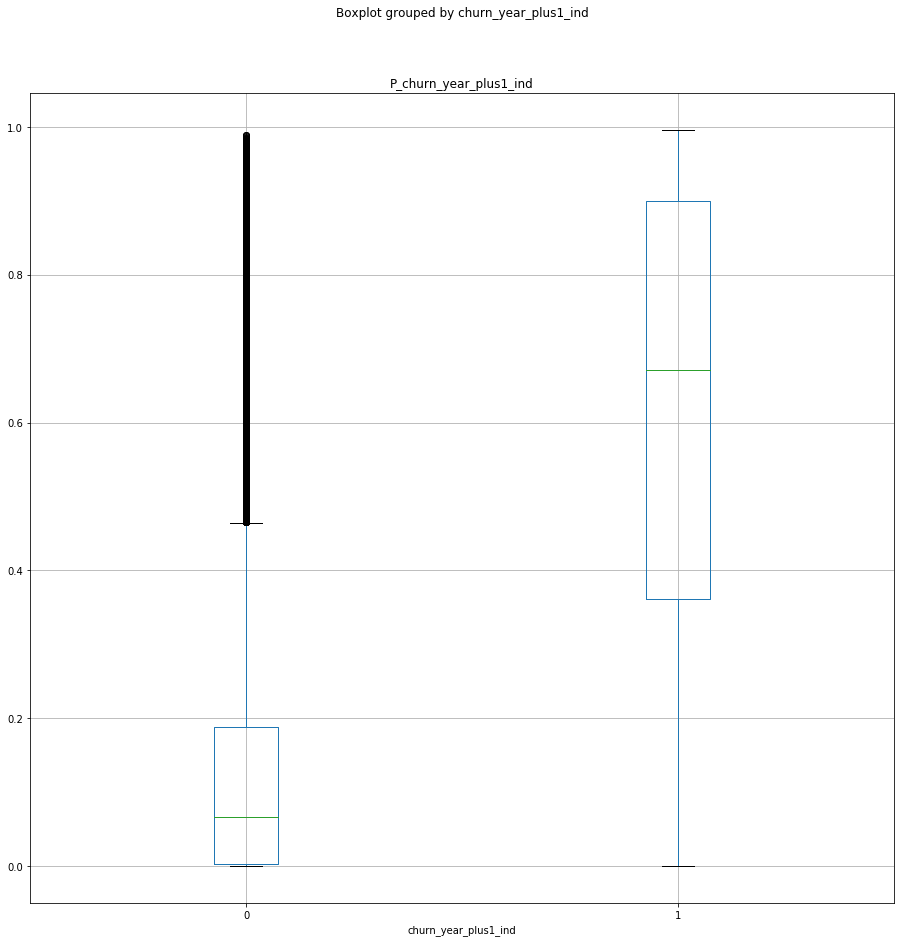

In [18]:
""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

""" joining predicted and actuals """
""" NOTE:  for reference, for now...to be used more later to create complete """
"""     dataframe with all obs and inputs and outputs """
train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error testn:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

## Now to try a more advanced Machine Learning algorithm to see if we can get a better model.
##    If you run this first with n_estimators=2000 (2000 iterations) you will see some degradation
##    in the model performance on the test set.  After that, you can scale back the iterations to 
##    something like 500 and rerun.

GB overall accuracy: 0.8763988850522112
AROC train:  0.9392397043632853
AROC test:  0.9347364281099397
 
MSE train: 0.0857195348648018
MSE test: 0.08865294257031205
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.08571953486480047
mean squared error test: 0.08865294257031266


Text(0, 0.5, 'AROC')

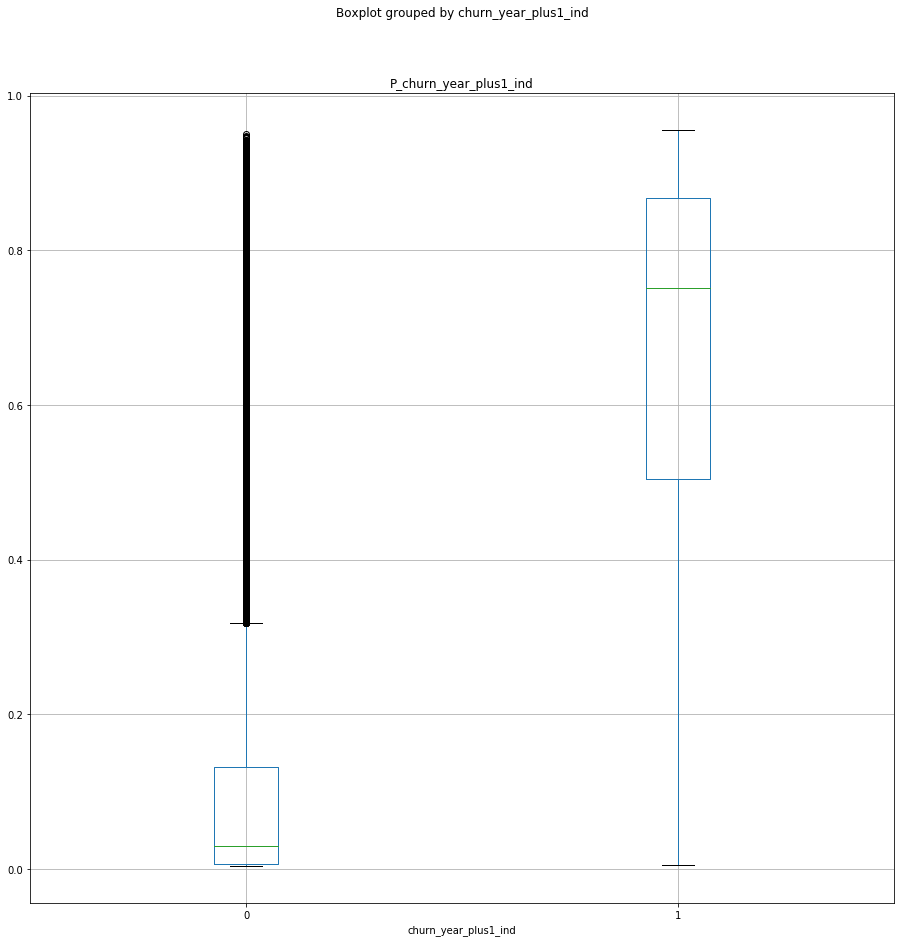

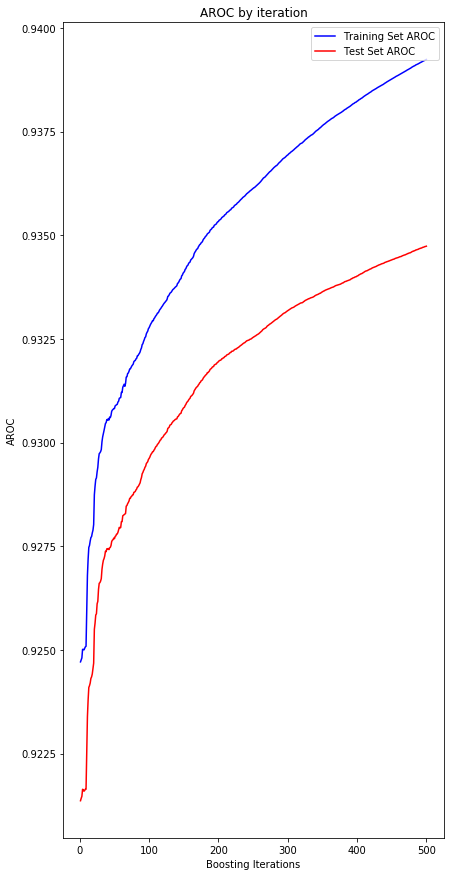

In [19]:
""" Gradient Boosting """
params = {'n_estimators': 500, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.01}
model2 = GradientBoostingClassifier(**params)

""" had to switch the order of X and Y for the fit to work with GradientBoosting """
result = model2.fit(x_train_selected_df, y_train_array)

""" returns overall accuracy"""
accuracy = model2.score(x_test_selected_df, y_test_df)
print("GB overall accuracy:", accuracy)

""" predicted values using the model """
""" using numpy copy to store result as an array """
""" manually adding a column header """
predict_train = pd.DataFrame(np.copy(model2.predict_proba(x_train_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(model2.predict_proba(x_test_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))

""" note that the index for the predicted values vector """
""" is reset, and thus complicates a join back with the original """
""" thus, reset the index on the original data, then join with predicted """
""" WARNING: you have to do the same, to join back with dataframe of regressors """
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)


test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error test:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))


pred_v_actual_test.boxplot(column='P_churn_year_plus1_ind', by='churn_year_plus1_ind',figsize=(15,15))

""" plotting AROC with each iteration of the Gradient Boosting algorithm """

""" converting Y dataframes into arrays as needed for logic below """
y_traint_array = y_train_df.values
y_test_array = y_test_df.values

test_AROC  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_AROC = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model2.staged_predict_proba(x_test_selected_df)):
    test_AROC[i] = metrics.roc_auc_score(y_test_array, y_pred[:, 1])

for i, y_pred in enumerate(model2.staged_predict_proba(x_train_selected_df)):
    train_AROC[i] = metrics.roc_auc_score(y_train_array, y_pred[:, 1])

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.title('AROC by iteration')
plt.plot(np.arange(params['n_estimators']) + 1, train_AROC, 'b-',
         label='Training Set AROC')
plt.plot(np.arange(params['n_estimators']) + 1, test_AROC, 'r-',
         label='Test Set AROC')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('AROC')


## Feature Importance for the Gradient Boosting Model:

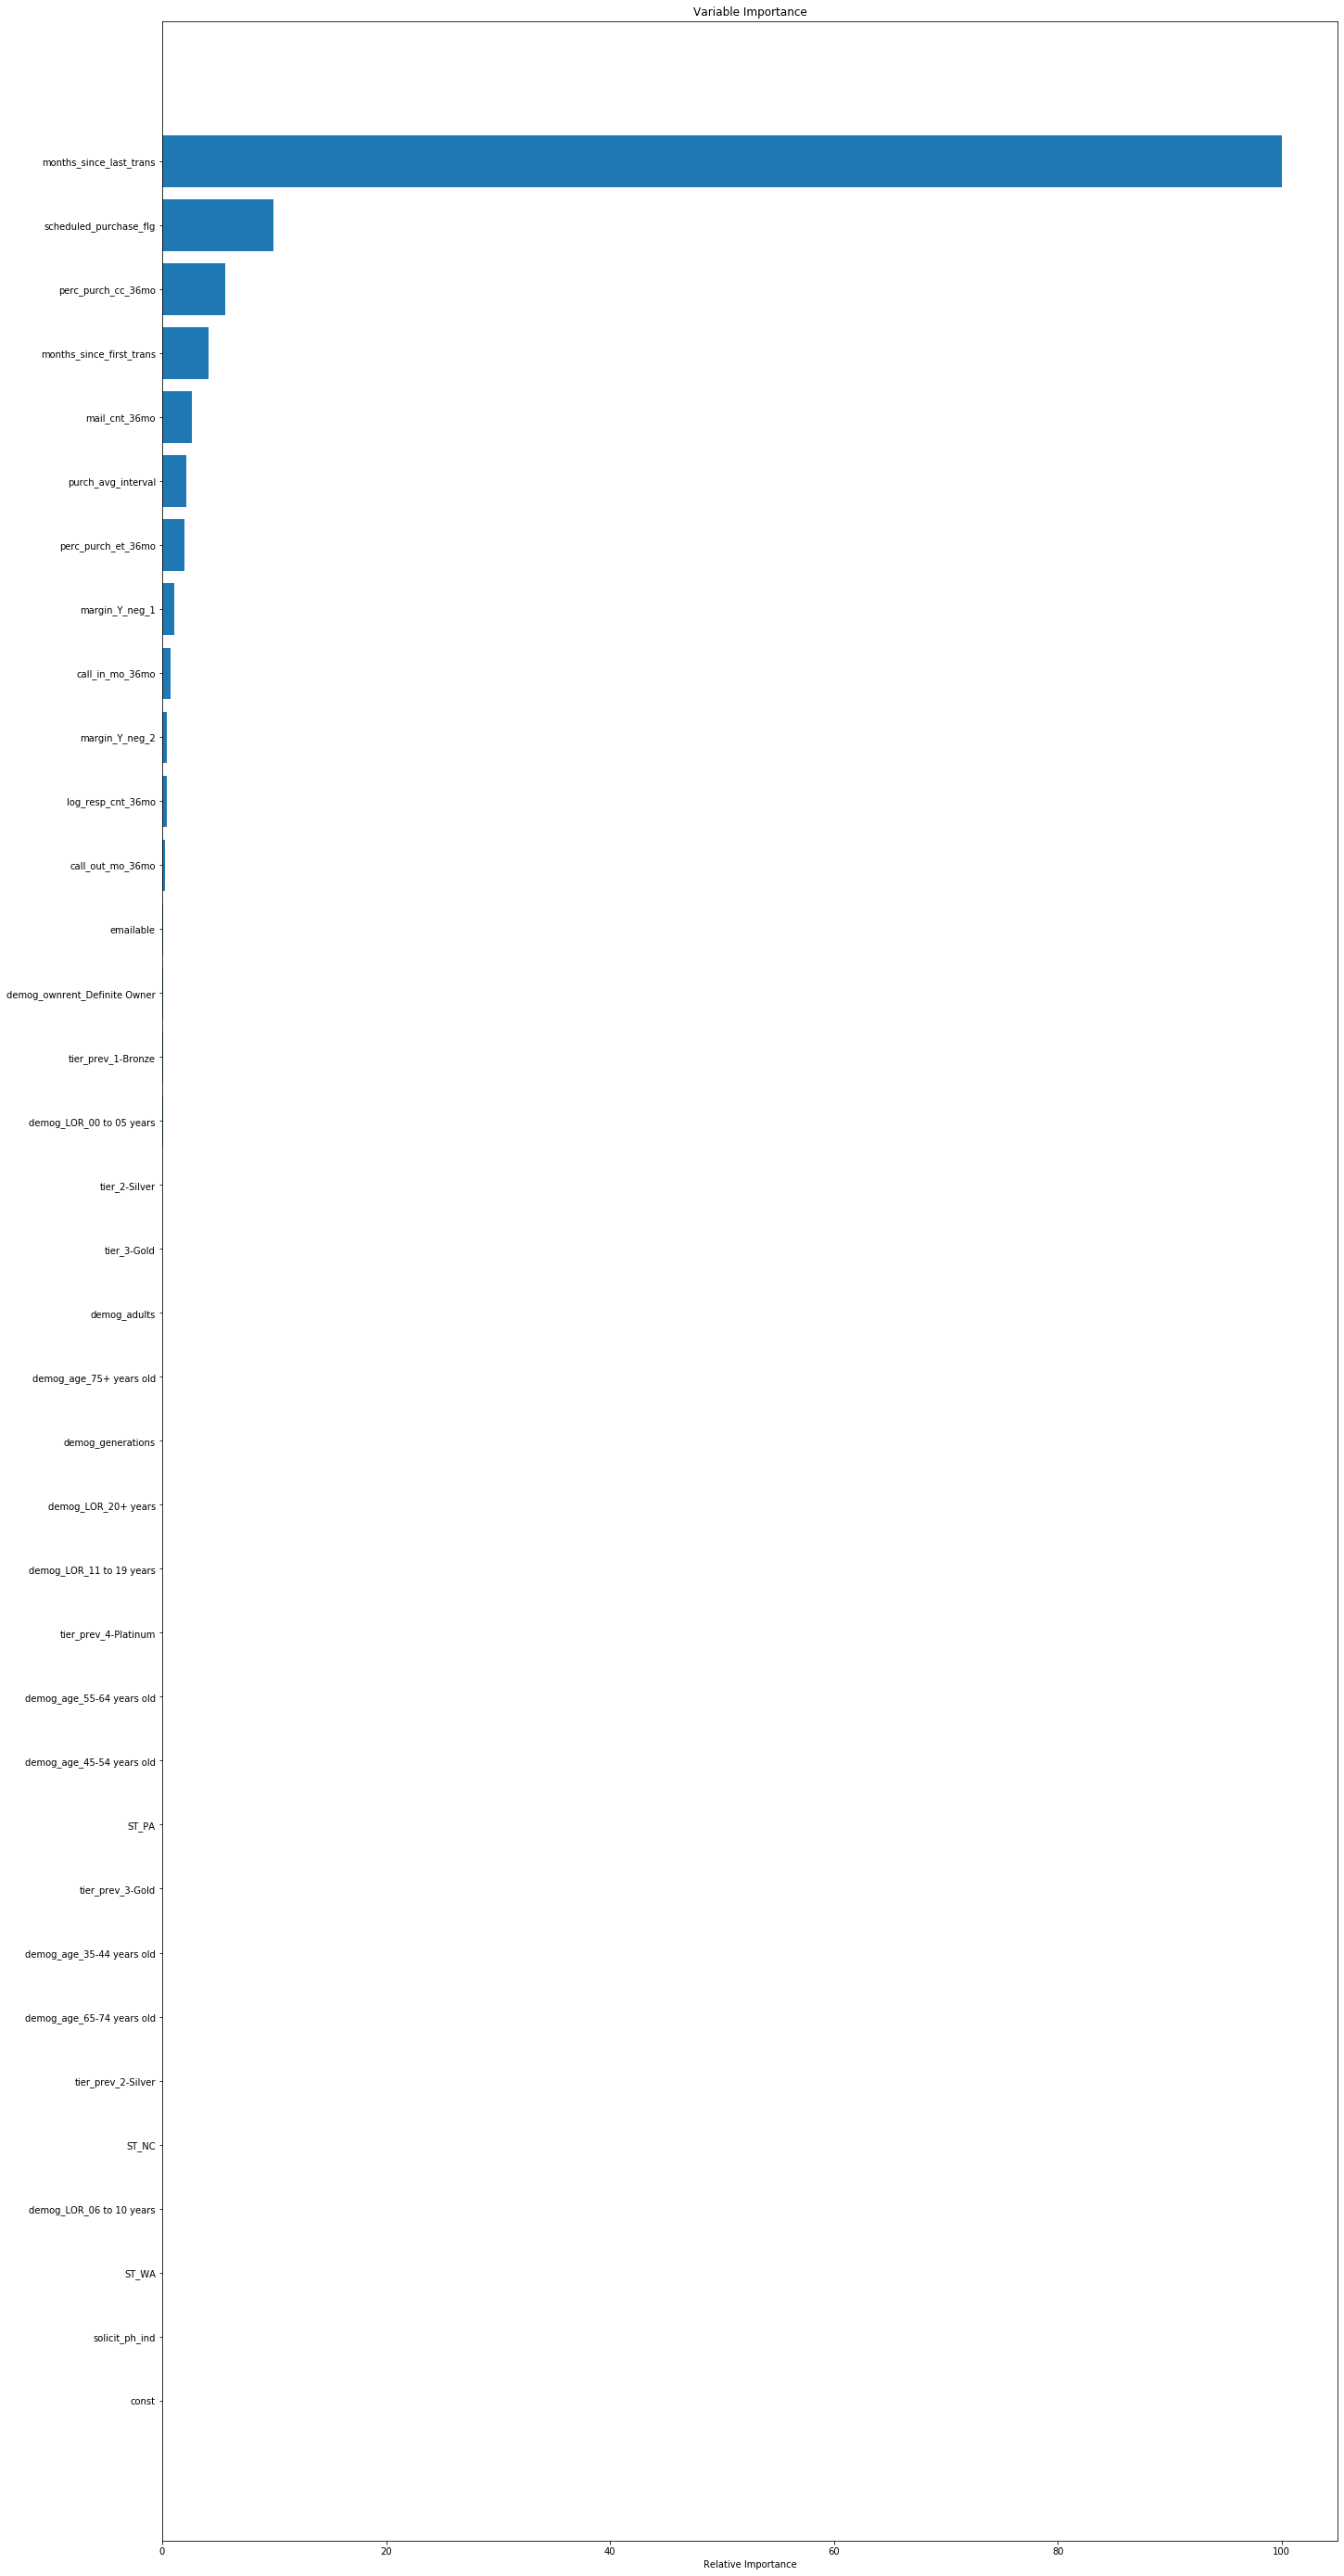

In [20]:
feature_importance = model2.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,50))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Appending the train and test sets, and keeping the acct_IDs and predicted churn probabilities

In [21]:
""" append together train and test predicted values, keeping only acct ID and predicted values """

pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_test, ignore_index=True)

pred_v_actual_train = pred_v_actual_train.drop(['churn_year_plus1_ind'
                             ],axis=1)

""" and then save predicted values by acct ID to csv """

pred_v_actual_train.to_csv(r'C:\Users\Ashish\OneDrive - Oklahoma A and M System\CLV\churn_scores.csv',index=False)
pred_v_actual_train.shape

(240368, 2)

## (back to lecture mode)